In [1]:
import argparse
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model

from mobiledet.models.keras_yolo import (preprocess_true_boxes,
                                     yolo_eval, yolo_head, yolo_loss)
from mobiledet.utils.draw_boxes import draw_boxes
from mobiledet.models.keras_darknet19 import darknet19
import argparse
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda
from keras.models import Model
import cv2
import copy

from mobiledet.models.keras_yolo import (preprocess_true_boxes, yolo_body_darknet19,
                                     yolo_body_mobilenet, yolo_eval, yolo_head, yolo_loss)
from mobiledet.utils.draw_boxes import draw_boxes
from mobiledet.utils import read_voc_datasets_train_batch, brightness_augment, augment_image
from mobiledet.models.keras_yolo import yolo_get_detector_mask

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
IMAGE_H = 608
IMAGE_W = 608

FEAT_W = IMAGE_W / 32
FEAT_H = IMAGE_H / 32

YOLO_ANCHORS = np.array(
    ((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),
     (7.88282, 3.52778), (9.77052, 9.16828)))
anchors = YOLO_ANCHORS 


In [3]:
drone_classes_path='model_data/drone_classes.txt'

with open(drone_classes_path) as f:
    drone_class_names = f.readlines()
drone_class_names = [c.strip() for c in drone_class_names]


In [4]:
data_path = '~/data/PascalVOC/VOCdevkit/pascal_voc_07_12.hdf5'
classes_path='model_data/pascal_classes.txt'

voc_path = os.path.expanduser(data_path)
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]
voc = h5py.File(voc_path, 'r')
num_training_data =  voc['train/boxes'].shape[0]

In [5]:
H5_BOXES = np.array(voc['train/boxes'])
H5_IMAGES = np.array(voc['train/images'])

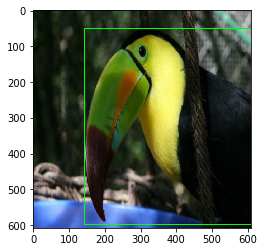

In [6]:
image_data, bboxes1 = read_voc_datasets_train_batch(H5_IMAGES, H5_BOXES, class_names, drone_class_names)

x,y = augment_image(image_data, bboxes1, 608, 608, jitter=True)

for box in y:
    cv2.rectangle(x,(int(box[1]),int(box[2])),(int(box[3]),int(box[4])),(0,255,0),2)
    
plt.imshow(x/255.)
plt.show()

In [24]:
class VOCBatchGenerator:
    def __init__(self, voc_path, 
                       model_w, 
                       model_h, 
                       feat_w,
                       feat_h, 
                       anchors,
                       voc_class_names,
                       class_names):

        self.voc_path = voc_path
        self.model_w = model_w
        self.model_h = model_h
        self.feat_w = feat_w
        self.feat_h = feat_h
        self.voc_class_names =  voc_class_names
        self.class_names =  class_names
        h5_data = h5py.File(voc_path, 'r')
        
        self.H5_BOXES = np.array(h5_data['train/boxes'])
        self.H5_IMAGES = np.array(h5_data['train/images'])
        self.anchors = anchors
    def flow2_from_hdf(self):
        anchors = self.anchors   
        num_img = H5_IMAGES.shape[0]
        if True:
            batch_images = []
            batch_boxes = []
            
            for i in range(BATCH_SIZE):        
                image_data, bboxes = read_voc_datasets_train_batch(self.H5_IMAGES, self.H5_BOXES, self.voc_class_names, self.class_names)
                image_data, bboxes = augment_image(image_data, bboxes, self.model_w, self.model_h, jitter=True)

                orig_size = np.array([image_data.shape[1], image_data.shape[0]])
                orig_size = np.expand_dims(orig_size, axis=0)
                image_data /= 255.
                batch_images.append(image_data)
                
                boxes = bboxes.reshape((-1, 5))
                boxes_xy = 0.5 * (boxes[:, 3:5] + boxes[:, 1:3])
                boxes_wh = boxes[:, 3:5] - boxes[:, 1:3]
                boxes_xy = boxes_xy / orig_size
                boxes_wh = boxes_wh / orig_size
                boxes = np.concatenate((boxes_xy, boxes_wh, boxes[:, 0:1]), axis=1)
                batch_boxes.append(boxes)

            
            # find the max number of boxes
            max_boxes = 0
            for boxz in batch_boxes:
                if boxz.shape[0] > max_boxes:
                    max_boxes = boxz.shape[0]
            
            # add zero pad for training
            for i, boxz in enumerate(batch_boxes):
                if boxz.shape[0]  < max_boxes:
                    zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
                    batch_boxes[i] = np.vstack((boxz, zero_padding))

                        
            batch_images = np.array(batch_images)
            batch_boxes = np.array(batch_boxes)
            
            detectors_mask, matching_true_boxes = yolo_get_detector_mask(batch_boxes, anchors, model_shape=[self.model_h, self.model_w])
            X_train = [batch_images, batch_boxes, detectors_mask, matching_true_boxes]
            y_train = np.zeros(len(batch_images))
            return X_train, y_train

In [12]:
def flow_from_hdf5():
    anchors = YOLO_ANCHORS 
    total_count = 0
    batch_count = 0
    
    num_img = H5_IMAGES.shape[0]
    if True:
        batch_images = []
        batch_boxes = []
        
        for i in range(BATCH_SIZE):        
            image_data, bboxes = read_voc_datasets_train_batch(H5_IMAGES, H5_BOXES, class_names, drone_class_names)
            image_data, bboxes = augment_image(image_data, bboxes, IMAGE_H, IMAGE_W, jitter=True)
            orig_size = np.array([image_data.shape[1], image_data.shape[0]])
            orig_size = np.expand_dims(orig_size, axis=0)
            image_data /= 255.
            batch_images.append(image_data)
            
            boxes = bboxes.reshape((-1, 5))
            boxes_xy = 0.5 * (boxes[:, 3:5] + boxes[:, 1:3])
            boxes_wh = boxes[:, 3:5] - boxes[:, 1:3]
            boxes_xy = boxes_xy / orig_size
            boxes_wh = boxes_wh / orig_size
            boxes = np.concatenate((boxes_xy, boxes_wh, boxes[:, 0:1]), axis=1)
            batch_boxes.append(boxes)

        
        # find the max number of boxes
        max_boxes = 0
        for boxz in batch_boxes:
            if boxz.shape[0] > max_boxes:
                max_boxes = boxz.shape[0]
        
        # add zero pad for training
        for i, boxz in enumerate(batch_boxes):
            if boxz.shape[0]  < max_boxes:
                zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
                batch_boxes[i] = np.vstack((boxz, zero_padding))

                    
        batch_images = np.array(batch_images)
        batch_boxes = np.array(batch_boxes)
        
        detectors_mask, matching_true_boxes = yolo_get_detector_mask(batch_boxes, anchors, model_shape=[608, 608])
        X_train = [batch_images, batch_boxes, detectors_mask, matching_true_boxes]
        y_train = np.zeros(len(batch_images))
        return X_train, y_train
            

In [26]:

batch_gen = VOCBatchGenerator(voc_path, IMAGE_W, IMAGE_H, FEAT_W, FEAT_H, anchors, class_names, drone_class_names)


# Images, Boxes = read_voc_datasets_train_batch(voc_path, batch_size=BATCH_SIZE)
# detectors_mask, matching_true_boxes = get_detector_mask(Boxes, anchors)
# X_train = [Images, Boxes, detectors_mask, matching_true_boxes]
# y_train = np.zeros(len(Images))
X_train, y_train = batch_gen.flow2_from_hdf5() 

In [14]:
from mobiledet.models.keras_yolo import (preprocess_true_boxes, yolo_body_darknet19,
                                     yolo_body_mobilenet, yolo_eval, yolo_head, yolo_loss)
from mobiledet.utils.draw_boxes import draw_boxes

detectors_mask_shape = (19, 19, 5, 1)
matching_boxes_shape = (19, 19, 5, 5)

# Create model input layers.
image_input = Input(shape=(608, 608, 3))
boxes_input = Input(shape=(None, 5))
detectors_mask_input = Input(shape=detectors_mask_shape)
matching_boxes_input = Input(shape=matching_boxes_shape)

# Create model body.
yolo_model = yolo_body_darknet19(image_input, len(anchors), len(class_names))
topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

In [22]:
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear')(topless_yolo.output)
model_body = Model(image_input, final_layer)
with tf.device('/cpu:0'):
    # TODO: Replace Lambda with custom Keras layer for loss.
    model_loss = Lambda(
        yolo_loss,
        output_shape=(1, ),
        name='yolo_loss',
        arguments={'anchors': anchors,
                   'num_classes': len(class_names)})([
                       model_body.output, boxes_input,
                       detectors_mask_input, matching_boxes_input
                   ])

model = Model(
    [model_body.input, boxes_input, detectors_mask_input,
     matching_boxes_input], model_loss)

In [27]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


model.compile(
    optimizer='adam', loss={
        'yolo_loss': lambda y_true, y_pred: y_pred
    })  # This is a hack to use the custom loss function in the last layer.

checkpoint = ModelCheckpoint("trained_stage_3_best.h5", monitor='val_loss',
                             save_weights_only=True, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

model.fit(X_train,
          y_train,
          validation_split=0.1,
          batch_size=1,
          epochs=10)


Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 143s - loss: 57.1532 - val_loss: 281869.1950
Epoch 2/10


KeyboardInterrupt: 